# Approach 1b: Comparing histograms with closest lapse image
Instead of comparing images directly (approach 1a), we compare the image histograms using the Kolmogorov-Smirnov test. We expect low "goodness of fit" values between the histograms for anomalous images since the appearance of an anomalous object would alter the histogram. Since color information is important (at least for daytime images), we compare the histogram of each color channel individually. Using a linear SVM, we try to classify new images as normal or anomalous.

### Advantages compared to approach 1a (pixel-wise comparison)
- less sensitive to camera movement
- less sensitive to small moving objects or dust particles
- almost not sensitive to noise
- color information is preserved

### Problems
- very sensitive to lighting changes
- loss of local information (we're only looking at the histogram)
- can easily be confused, e.g. by green or brown animals
- color information is useless at night

In [2]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from py.Dataset import Dataset
from py.DatasetStatistics import DatasetStatistics
from py.Session import Session, MotionImage, LapseImage
from py.FileUtils import list_folders, list_jpegs_recursive
from py.ImageUtils import display_images

DIR = '/home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/' # dataset directory
SCALE = 0.2 # scaling factor for all images

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 32 sessions
Session 'Beaver_01' at folder: /home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


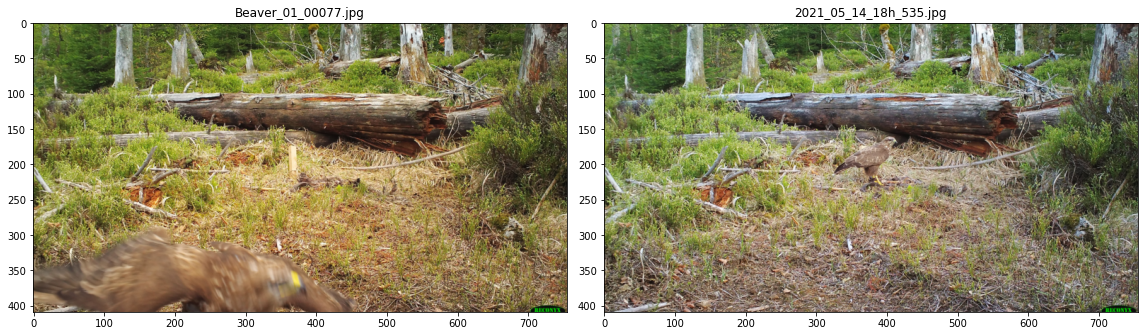

In [4]:
motion_img = session.get_random_motion_image(day_only=True)
before_img, after_img, rel = motion_img.get_closest_lapse_images()
comp_img = before_img if rel <= 0.5 else after_img
motion_arr = motion_img.read(scale=SCALE, gray=False)
comp_arr = comp_img.read(scale=SCALE, gray=False)
display_images([motion_arr, comp_arr], [motion_img.filename, comp_img.filename])

In [5]:
hists = [np.histogram(motion_arr[:,:,i], bins=256, range=(0, 1), density=True) for i in range(3)]
comp_hists = [np.histogram(comp_arr[:,:,i], bins=256, range=(0, 1), density=True) for i in range(3)]

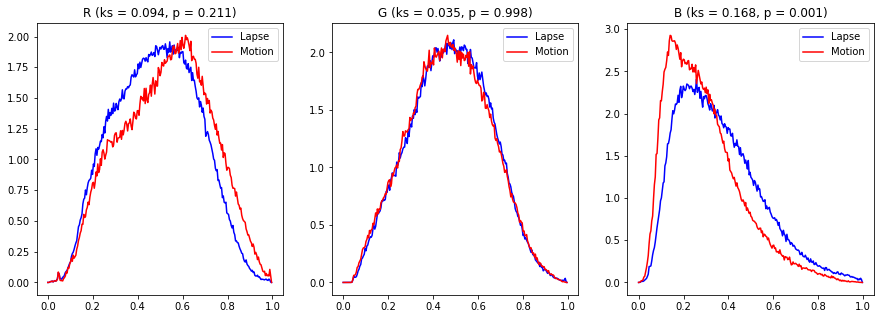

In [6]:
from scipy.stats import ks_2samp

plt.figure(figsize=(15, 5))
for channel, channel_name in enumerate(["R", "G", "B"]):
    # calculate Kolmogorov-Smirnov test
    ks, p = ks_2samp(comp_hists[channel][0], hists[channel][0])

    # plot
    plt.subplot(1, 3, channel + 1)
    plt.plot(comp_hists[channel][1][:-1], comp_hists[channel][0], color="blue", label="Lapse")
    plt.plot(hists[channel][1][:-1], hists[channel][0], color="red", label="Motion")
    plt.title(f"{channel_name} (ks = {ks:.3f}, p = {p:.3f})")
    plt.legend()
plt.show()

## Complete test

In [85]:
results = []

for img in tqdm(session.generate_motion_images()):
    before_img, after_img, rel = img.get_closest_lapse_images()
    if rel < 0:
        continue
    comp_img = before_img if rel <= 0.5 else after_img
    motion_arr = img.read(scale=1, gray=False)
    comp_arr = comp_img.read(scale=1, gray=False)
    assert motion_arr.dtype == "uint8" and comp_arr.dtype == "uint8"

    # Calculate histograms
    hists = [np.histogram(motion_arr[:,:,channel], bins=256, range=(0, 255), density=True) for channel in range(3)]
    comp_hists = [np.histogram(comp_arr[:,:,channel], bins=256, range=(0, 255), density=True) for channel in range(3)]

    # Compare each channel using Kolmogorov-Smirnov test
    vals = [list(ks_2samp(comp_hists[channel][0], hists[channel][0])) for channel in range(3)]
    results.append([img.filename, *vals])

0it [00:00, ?it/s]

In [86]:
# np.save("approach1b_results.npy", results)

/home/kleinsteuber/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [87]:
results = np.load("approach1b_results.npy", allow_pickle=True)
results

array([['Beaver_01_00134.jpg', list([0.26171875, 4.088683979943013e-08]),
        list([0.33203125, 6.817792971198432e-13]),
        list([0.09375, 0.21079241063602555])],
       ['Beaver_01_00329.jpg', list([0.125, 0.03653528919210504]),
        list([0.19140625, 0.00016243284285739554]),
        list([0.07421875, 0.48189738517204367])],
       ['Beaver_01_00167.jpg', list([0.10546875, 0.11597166955800203]),
        list([0.1015625, 0.14267260644590424]),
        list([0.10546875, 0.11597166955800203])],
       ...,
       ['Beaver_01_00658.jpg', list([0.30859375, 3.633414131125328e-11]),
        list([0.30859375, 3.633414131125328e-11]),
        list([0.30859375, 3.633414131125328e-11])],
       ['Beaver_01_00355.jpg', list([0.21875, 8.877552097322398e-06]),
        list([0.21875, 8.877552097322398e-06]),
        list([0.21875, 8.877552097322398e-06])],
       ['Beaver_01_00202.jpg', list([0.0859375, 0.3013522815409377]),
        list([0.16796875, 0.0014307302331222763]),
        lis

In [98]:
from py.Labels import LABELS


normal = []
anomalous = []
small_anomalous = []
for filename, r, g, b in results:
    vals = [r[0], g[0], b[0], r[1], g[1], b[1]] # p values of all channels
    if int(filename[10:-4]) in LABELS["Beaver_01"]["normal"]:
        normal.append(vals)
    elif int(filename[10:-4]) in LABELS["Beaver_01"]["small"]:
        small_anomalous.append(vals)
    else:
        anomalous.append(vals)
normal = np.array(normal)
anomalous = np.array(anomalous)
small_anomalous = np.array(small_anomalous)

### 3d plot of ks values

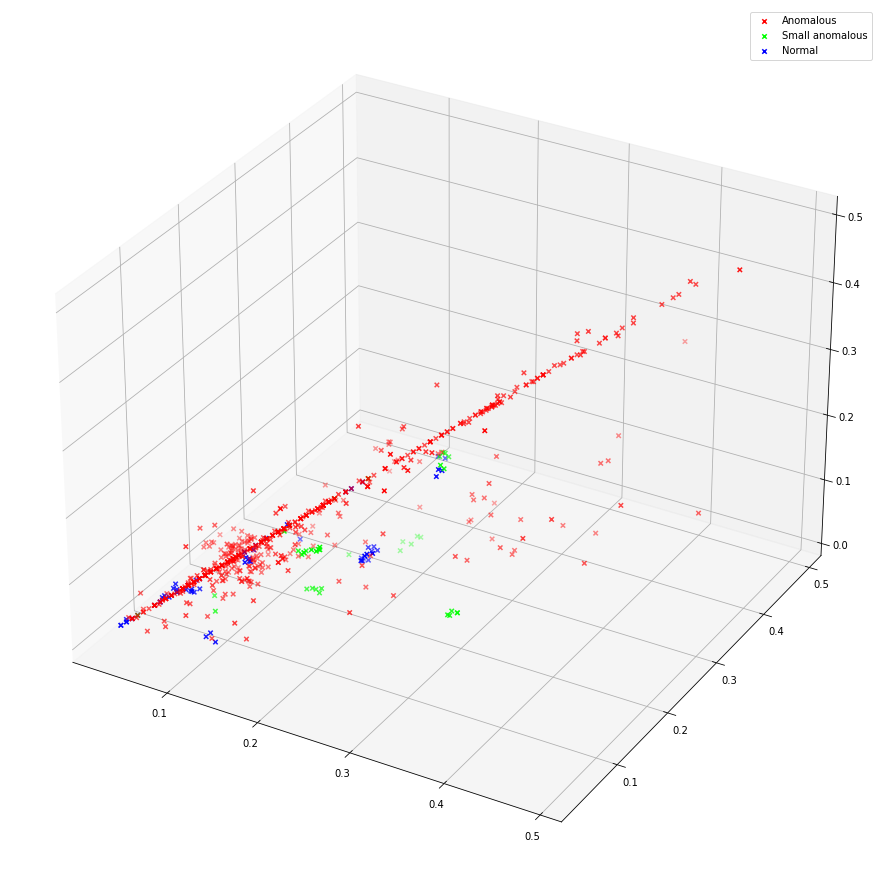

In [99]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(anomalous[:,0], anomalous[:,1], anomalous[:,2], label="Anomalous", color="red", marker="x")
ax.scatter(small_anomalous[:,0], small_anomalous[:,1], small_anomalous[:,2], label="Small anomalous", color="lime", marker="x")
ax.scatter(normal[:,0], normal[:,1], normal[:,2], label="Normal", color="blue", marker="x")
# ax.xscale("log")
# ax.yscale("log")
plt.legend()

plt.show()

### 3d plot of p values

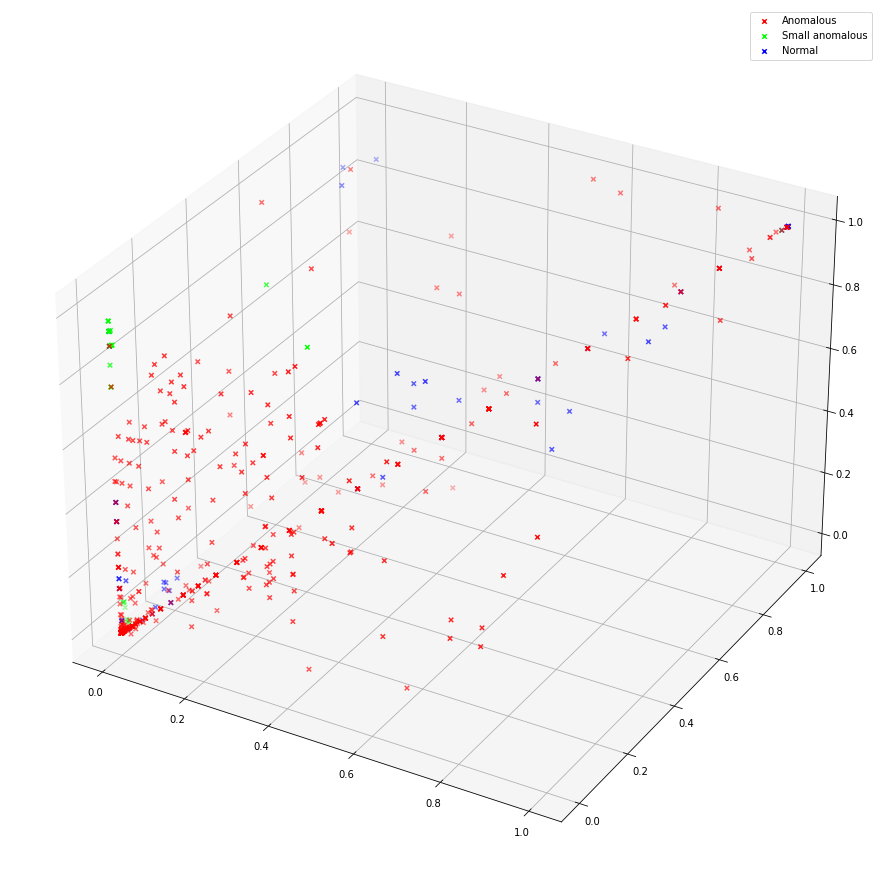

In [100]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(anomalous[:,3], anomalous[:,4], anomalous[:,5], label="Anomalous", color="red", marker="x")
ax.scatter(small_anomalous[:,3], small_anomalous[:,4], small_anomalous[:,5], label="Small anomalous", color="lime", marker="x")
ax.scatter(normal[:,3], normal[:,4], normal[:,5], label="Normal", color="blue", marker="x")
# ax.xscale("log")
# ax.yscale("log")
plt.legend()

plt.show()

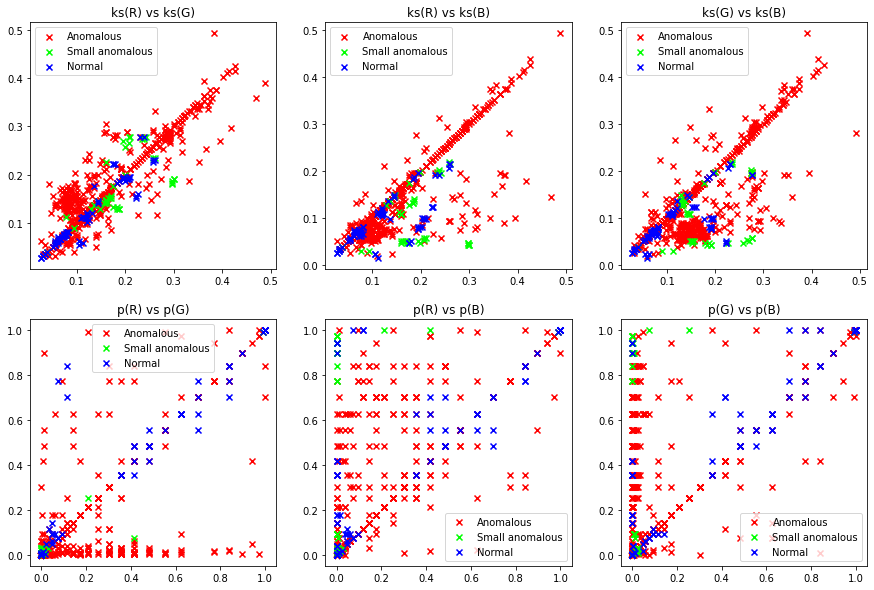

In [102]:
fig = plt.figure(figsize=(15,10))
channels = ["ks(R)", "ks(G)", "ks(B)", "p(R)", "p(G)", "p(B)"]
i = 0
for c1, c2 in [(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5)]:
    i += 1
    plt.subplot(2, 3, i)
    plt.scatter(anomalous[:,c1], anomalous[:,c2], label="Anomalous", color="red", marker="x")
    plt.scatter(small_anomalous[:,c1], small_anomalous[:,c2], label="Small anomalous", color="lime", marker="x")
    plt.scatter(normal[:,c1], normal[:,c2], label="Normal", color="blue", marker="x")
    plt.legend()
    plt.title(f"{channels[c1]} vs {channels[c2]}")
plt.show()

In [126]:
from sklearn import svm

train_split = 0.6
np.random.shuffle(anomalous)
np.random.shuffle(small_anomalous)
np.random.shuffle(normal)
s1 = int(train_split*len(anomalous))
s2 = int(train_split*len(small_anomalous))
s3 = int(train_split*len(normal))
anomalous_train = np.concatenate((anomalous[:s1], small_anomalous[:s2]))
anomalous_test = np.concatenate((anomalous[s1:], small_anomalous[s2:]))
normal_train = normal[:s3]
normal_test = normal[s3:]

# make anomalies and normals balanced
np.random.shuffle(anomalous_train)
anomalous_train = anomalous_train[:len(normal_train)]
np.random.shuffle(anomalous_test)
anomalous_test = anomalous_test[:len(normal_test)]

X_train = np.concatenate((anomalous_train, normal_train))
y_train = np.concatenate((np.ones(anomalous_train.shape[0]), np.zeros(normal_train.shape[0])))

X_test = np.concatenate((anomalous_test, normal_test))
y_test = np.concatenate((np.ones(anomalous_test.shape[0]), np.zeros(normal_test.shape[0])))

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [127]:
print("train accuracy:", clf.score(X_train, y_train))
print("test accuracy:", clf.score(X_test, y_test))

train accuracy: 0.7159090909090909
test accuracy: 0.7333333333333333


In [128]:
pred_test = clf.predict(X_test)
correct = 0
false_anomalies = 0
false_normals = 0
for y, pred in zip(y_test, pred_test):
    if y == pred:
        correct += 1
    elif y == 0 and pred == 1:
        # predicted anomaly but normal
        false_anomalies += 1
    else:
        # predicted normal but anomaly
        false_normals += 1
print(f"Correct: {correct}")
print(f"False anomalies: {false_anomalies}")
print(f"False normals (bad): {false_normals}")

Correct: 44
False anomalies: 14
False normals (bad): 2
